In [25]:
import numpy as np
import optuna
import sys
import joblib
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib
import lightgbm as lgb
import xgboost as xgb 
from sklearn.ensemble import RandomForestRegressor
import pickle
from sklearn.inspection import permutation_importance

### Data Loading

In [26]:
filepath = '../../split_year_data'

In [27]:
train = {}
for fold in range(0, 5):
    tdata_x85 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_85.csv')
    tdata_x85 = tdata_x85.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y85 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_85.csv')
    tdata_y85 = tdata_y85.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x95 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_95.csv')
    tdata_x95 = tdata_x95.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y95 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_95.csv')
    tdata_y95 = tdata_y95.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x1 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_1.csv')
    tdata_x1 = tdata_x1.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y1 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_1.csv')
    tdata_y1 = tdata_y1.drop(columns=['Unnamed: 0'], axis=1)

    train[fold] = [tdata_x85, tdata_y85, tdata_x95, tdata_y95, tdata_x1, tdata_y1]

In [28]:
validation = {}
for fold in range(0, 5):
    vdata_x = pd.read_csv(filepath + '/val/X_val_' + str(fold) + '.csv')
    vdata_x = vdata_x.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y = pd.read_csv(filepath + '/val/y_val_' + str(fold) + '.csv')
    vdata_y = vdata_y.drop(columns=['Unnamed: 0'], axis=1)
    validation[fold] = [vdata_x, vdata_y]

In [29]:
with open('../../split_year_data/countries_dict.pkl', 'rb') as f:
    countries_dict = pickle.load(f)

In [30]:
output_dir = '../../split_year_models'

### Random Forest

In [33]:
rf_imp_1_mean = []
rf_imp_95_mean = []
rf_imp_85_mean = []

rf_imp_1_std = []
rf_imp_95_std = []
rf_imp_85_std = []

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '95'
        else: name = '1'

        train_input_data = train[fold][thresh * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].map(countries_dict)

        val_input_data = validation[fold][0].copy()
        val_input_data['setting'] = val_input_data['setting'].map(countries_dict)
        val_input_data['setting'] = val_input_data['setting'].astype("category")
        val_label = validation[fold][1].copy()

        columns_needed = val_input_data.columns.intersection(train_input_data.columns)
        val_relevant_input = val_input_data[columns_needed]

        best_params = joblib.load(f"{output_dir}/random_forest/best_params_{fold}_{name}.pkl")

        loaded_model = RandomForestRegressor(**best_params)
        train_load = loaded_model.fit(train_input_data, train[fold][thresh * 2 + 1])
        feature_permute = permutation_importance(train_load, val_relevant_input, val_label, n_repeats=10, random_state=42)

        if thresh == 0:
            rf_imp_85_mean.append(feature_permute.importances_mean)
            rf_imp_85_std.append(feature_permute.importances_std)
        if thresh == 1:
            rf_imp_95_mean.append(feature_permute.importances_mean)
            rf_imp_95_std.append(feature_permute.importances_std)
        elif thresh == 2:
            rf_imp_1_mean.append(feature_permute.importances_mean)
            rf_imp_1_std.append(feature_permute.importances_std)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

### LightGBM

In [31]:
lgb_imp_1_mean = []
lgb_imp_95_mean = []
lgb_imp_85_mean = []

lgb_imp_1_std = []
lgb_imp_95_std = []
lgb_imp_85_std = []

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '95'
        else: name = '1'

        train_input_data = train[fold][thresh * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")
        train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        train_label = train[fold][thresh * 2 + 1].copy()
        train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        val_input_data = validation[fold][0].copy()
        val_input_data['setting'] = val_input_data['setting'].astype("category")
        val_input_data.columns = val_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        val_label = validation[fold][1].copy()
        val_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        val_data = val_input_data[train_input_data.columns].copy()

        best_params = joblib.load(f"{output_dir}/lightgbm/best_params_{fold}_{name}.pkl")

        loaded_model = lgb.LGBMRegressor(**best_params, verbosity = -1)

        train_load = loaded_model.fit(train_input_data, train_label)
        feature_permute = permutation_importance(train_load, val_data, val_label, n_repeats=10, random_state=42)

        if thresh == 0:
            lgb_imp_85_mean.append(feature_permute.importances_mean)
            lgb_imp_85_std.append(feature_permute.importances_std)
        if thresh == 1:
            lgb_imp_95_mean.append(feature_permute.importances_mean)
            lgb_imp_95_std.append(feature_permute.importances_std)
        elif thresh == 2:
            lgb_imp_1_mean.append(feature_permute.importances_mean)
            lgb_imp_1_std.append(feature_permute.importances_std)

### XGBoost

In [32]:
xgb_imp_1_mean = []
xgb_imp_95_mean = []
xgb_imp_85_mean = []

xgb_imp_1_std = []
xgb_imp_95_std = []
xgb_imp_85_std = []

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):

        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '95'
        else: name = '1'

        train_input_data = train[fold][thresh * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")

        val_input_data = validation[fold][0].copy()
        val_input_data['setting'] = val_input_data['setting'].astype("category")
        val_label = validation[fold][1].copy()

        columns_needed = val_input_data.columns.intersection(train_input_data.columns)
        val_relevant_input = val_input_data[columns_needed]

        bp = joblib.load(f"{output_dir}/xgboost/best_params_{fold}_{name}.pkl")
        best_params = {'n_estimators' : bp['number_trees'], 'max_depth' : bp['max_tree_depth'], 'booster' : bp['boosting_type'], 'reg_alpha' : bp['l1_norm'], 
            'reg_lambda' : bp['l2_norm'], 'subsample' : bp['subsample'], 'learning_rate' : bp['learning_rate']}

        loaded_model = xgb.XGBRegressor(**best_params, enable_categorical=True)
        train_load = loaded_model.fit(train_input_data, train[fold][thresh * 2 + 1])
        feature_permute = permutation_importance(train_load, val_relevant_input, val_label, n_repeats=10, random_state=42)

        if thresh == 0:
            xgb_imp_85_mean.append(feature_permute.importances_mean)
            xgb_imp_85_std.append(feature_permute.importances_std)
        if thresh == 1:
            xgb_imp_95_mean.append(feature_permute.importances_mean)
            xgb_imp_95_std.append(feature_permute.importances_std)
        elif thresh == 2:
            xgb_imp_1_mean.append(feature_permute.importances_mean)
            xgb_imp_1_std.append(feature_permute.importances_std)

### Saving

In [34]:
with open('../../fs_frommodel_models/year/rf_imp_1_mean.pkl', 'wb') as f:
    pickle.dump(rf_imp_1_mean, f)
with open('../../fs_frommodel_models/year/rf_imp_95_mean.pkl', 'wb') as f:
    pickle.dump(rf_imp_95_mean, f)
with open('../../fs_frommodel_models/year/rf_imp_85_mean.pkl', 'wb') as f:
    pickle.dump(rf_imp_85_mean, f)

with open('../../fs_frommodel_models/year/rf_imp_1_std.pkl', 'wb') as f:
    pickle.dump(rf_imp_1_std, f)
with open('../../fs_frommodel_models/year/rf_imp_95_std.pkl', 'wb') as f:
    pickle.dump(rf_imp_95_std, f)
with open('../../fs_frommodel_models/year/rf_imp_85_std.pkl', 'wb') as f:
    pickle.dump(rf_imp_85_std, f)

In [35]:
with open('../../fs_frommodel_models/year/lgb_imp_1_mean.pkl', 'wb') as f:
    pickle.dump(lgb_imp_1_mean, f)
with open('../../fs_frommodel_models/year/lgb_imp_95_mean.pkl', 'wb') as f:
    pickle.dump(lgb_imp_95_mean, f)
with open('../../fs_frommodel_models/year/lgb_imp_85_mean.pkl', 'wb') as f:
    pickle.dump(lgb_imp_85_mean, f)

with open('../../fs_frommodel_models/year/lgb_imp_1_std.pkl', 'wb') as f:
    pickle.dump(lgb_imp_1_std, f)
with open('../../fs_frommodel_models/year/lgb_imp_95_std.pkl', 'wb') as f:
    pickle.dump(lgb_imp_95_std, f)
with open('../../fs_frommodel_models/year/lgb_imp_85_std.pkl', 'wb') as f:
    pickle.dump(lgb_imp_85_std, f)

In [36]:
with open('../../fs_frommodel_models/year/xgb_imp_1_mean.pkl', 'wb') as f:
    pickle.dump(xgb_imp_1_mean, f)
with open('../../fs_frommodel_models/year/xgb_imp_95_mean.pkl', 'wb') as f:
    pickle.dump(xgb_imp_95_mean, f)
with open('../../fs_frommodel_models/year/xgb_imp_85_mean.pkl', 'wb') as f:
    pickle.dump(xgb_imp_85_mean, f)

with open('../../fs_frommodel_models/year/xgb_imp_1_std.pkl', 'wb') as f:
    pickle.dump(xgb_imp_1_std, f)
with open('../../fs_frommodel_models/year/xgb_imp_95_std.pkl', 'wb') as f:
    pickle.dump(xgb_imp_95_std, f)
with open('../../fs_frommodel_models/year/xgb_imp_85_std.pkl', 'wb') as f:
    pickle.dump(xgb_imp_85_std, f)

### Comparisons

In [37]:
lgb_avg_1 = np.mean(lgb_imp_1_mean, axis=0)
lgb_std_1 = np.mean(lgb_imp_1_std, axis=0)
lgb_avg_1 = np.mean(lgb_imp_1_mean, axis=0)

names1 = train[0][2 * 2].columns

# Wrap in DataFrame
lgb_avg_1_df = pd.DataFrame({
    'Feature': names1,
    'Avg_Permutation_Importance LGBM Threshold = None': lgb_avg_1,
    'Std' : lgb_std_1
}).sort_values(by='Avg_Permutation_Importance LGBM Threshold = None', ascending=False)

lgb_1_imp_pos = lgb_avg_1_df[lgb_avg_1_df['Avg_Permutation_Importance LGBM Threshold = None'] - lgb_avg_1_df['Std'] > 0]
lgb_1_imp_pos_big = lgb_1_imp_pos[lgb_avg_1_df['Avg_Permutation_Importance LGBM Threshold = None'] > 0.001]
print(lgb_1_imp_pos_big.shape)
lgb_1_imp_pos_big
#lgb_avg_1_df.plot.bar(x = 'Feature', yerr='Std', figsize=(15, 8))

(55, 3)


/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5975/1679935638.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lgb_1_imp_pos_big = lgb_1_imp_pos[lgb_avg_1_df['Avg_Permutation_Importance LGBM Threshold = None'] > 0.001]


,Feature,Avg_Permutation_Importance LGBM Threshold = None,Std
641,Vulnerable employment (% of total employment) ...,0.175278,0.012457
16,"Survival to age 65, female (% of cohort)",0.027263,0.004782
116,"Stillbirth rate (per 1,000 total births)",0.026017,0.002682
137,"Mortality rate, adult, female (per 1,000 femal...",0.022193,0.003194
174,"Mortality rate, under-5 (per 1,000 live births)",0.015704,0.002591
88,"Contraceptive prevalence, any modern method (%...",0.014584,0.000945
643,Wage and salaried workers (% of total employme...,0.012077,0.002736
111,"Prevalence of overweight, male (% of male adults)",0.010033,0.002228
2,setting,0.009613,0.001625
46,Women's share of population ages 15+ living wi...,0.009143,0.002053


In [38]:
rf_avg_1 = np.mean(rf_imp_1_mean, axis=0)
rf_std_1 = np.mean(rf_imp_1_std, axis=0)
rf_avg_1_df = pd.DataFrame({
    'Feature': names1,
    'Avg_Permutation_Importance RF Threshold = None': rf_avg_1,
    'Std' : rf_std_1
}).sort_values(by='Avg_Permutation_Importance RF Threshold = None', ascending=False)
rf_1_imp_pos = rf_avg_1_df[rf_avg_1_df['Avg_Permutation_Importance RF Threshold = None'] - rf_avg_1_df['Std'] > 0]
rf_1_imp_pos_big = rf_1_imp_pos[rf_avg_1_df['Avg_Permutation_Importance RF Threshold = None'] > 0.001]
print(rf_1_imp_pos_big.shape)
rf_1_imp_pos_big

(27, 3)


/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5975/1706408803.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rf_1_imp_pos_big = rf_1_imp_pos[rf_avg_1_df['Avg_Permutation_Importance RF Threshold = None'] > 0.001]


,Feature,Avg_Permutation_Importance RF Threshold = None,Std
641,Vulnerable employment (% of total employment) ...,0.230401,0.011555
139,"Fertility rate, total (births per woman)",0.023517,0.003294
137,"Mortality rate, adult, female (per 1,000 femal...",0.019837,0.002753
16,"Survival to age 65, female (% of cohort)",0.018613,0.002483
637,"Self-employed, total (% of total employment) (...",0.010649,0.001535
643,Wage and salaried workers (% of total employme...,0.010483,0.001583
116,"Stillbirth rate (per 1,000 total births)",0.005635,0.001091
72,"Survival to age 65, male (% of cohort)",0.005078,0.000443
30,"Mortality rate, under-5, male (per 1,000 live ...",0.003993,0.001188
85,"Mortality rate, infant, female (per 1,000 live...",0.003576,0.001374


In [39]:
xgb_avg_1 = np.mean(xgb_imp_1_mean, axis=0)
xgb_std_1 = np.mean(xgb_imp_1_std, axis=0)
xgb_avg_1_df = pd.DataFrame({
    'Feature': names1,
    'Avg_Permutation_Importance xgb Threshold = None': xgb_avg_1,
    'Std' : xgb_std_1
}).sort_values(by='Avg_Permutation_Importance xgb Threshold = None', ascending=False)
xgb_1_imp_pos = xgb_avg_1_df[xgb_avg_1_df['Avg_Permutation_Importance xgb Threshold = None'] - xgb_avg_1_df['Std'] > 0]
xgb_1_imp_pos_big = xgb_1_imp_pos[xgb_avg_1_df['Avg_Permutation_Importance xgb Threshold = None'] > 0.001]
print(xgb_1_imp_pos_big.shape)
xgb_1_imp_pos_big

(1, 3)


/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5975/2781861880.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xgb_1_imp_pos_big = xgb_1_imp_pos[xgb_avg_1_df['Avg_Permutation_Importance xgb Threshold = None'] > 0.001]


,Feature,Avg_Permutation_Importance xgb Threshold = None,Std
10,"Mortality rate, infant (per 1,000 live births)",0.001296,0.000087


In [40]:
rf_lgb_1_intersection = set(lgb_1_imp_pos_big['Feature']) & set(rf_1_imp_pos_big['Feature'])
len(rf_lgb_1_intersection)

18

In [45]:
rf_lgb_1_intersection

{'Adolescent fertility rate (births per 1,000 women ages 15-19)',
 'Births attended by skilled health staff (% of total)',
 'Contraceptive prevalence, any method (% of married women ages 15-49)',
 'Employment in industry (% of total employment) (modeled ILO estimate) male',
 'Fertility rate, total (births per woman)',
 'Mortality rate, adult, female (per 1,000 female adults)',
 'Mortality rate, infant (per 1,000 live births)',
 'Mortality rate, under-5 (per 1,000 live births)',
 'Mortality rate, under-5, male (per 1,000 live births)',
 'Number of infant deaths, male',
 'People practicing open defecation (% of population)',
 'People practicing open defecation, rural (% of rural population)',
 'Self-employed, total (% of total employment) (modeled ILO estimate) female',
 'Stillbirth rate (per 1,000 total births)',
 'Survival to age 65, female (% of cohort)',
 'Vulnerable employment (% of total employment) (modeled ILO estimate) female',
 'Wage and salaried workers (% of total employment)

In [41]:
rf_only = []
for feature_name in rf_1_imp_pos_big['Feature']:
    if feature_name not in rf_lgb_1_intersection:
        rf_only.append(feature_name)

rf_only

['Survival to age 65, male (% of cohort)',
 'Mortality rate, infant, female (per 1,000 live births)',
 'Incidence of HIV, ages 15-49, male (per 1,000 uninfected male population ages 15-49)',
 'Mortality rate, adult, male (per 1,000 male adults)',
 'Incidence of HIV, ages 15-49 (per 1,000 uninfected population ages 15-49)',
 'Mortality rate, under-5, female (per 1,000 live births)',
 'Progression to secondary school (%) male',
 'Employment in agriculture (% of total employment) (modeled ILO estimate) female',
 'Lower secondary completion rate (% of relevant age group) female']

In [42]:
lgb_only = []
for feature_name in lgb_1_imp_pos_big['Feature']:
    if feature_name not in rf_lgb_1_intersection:
        lgb_only.append(feature_name)

lgb_only

['Contraceptive prevalence, any modern method (% of married women ages 15-49)',
 'Prevalence of overweight, male (% of male adults)',
 'setting',
 'Wage and salaried workers (% of total employment) (modeled ILO estimate) male',
 'Prevalence of HIV, female (% ages 15-24)',
 'Demand for family planning satisfied by any methods (% of married women with demand for family planning)',
 'Prevalence of underweight, weight for age, male (% of children under 5)',
 'Mortality rate, infant, male (per 1,000 live births)',
 'Vulnerable employment (% of total employment) (modeled ILO estimate) male',
 'Contributing family workers (% of total employment) (modeled ILO estimate) female',
 'Prevalence of HIV, male (% ages 15-24)',
 'Number of under-five deaths, male',
 'Mortality caused by road traffic injury, female (per 100,000 female population)',
 'Teenage mothers (% of women ages 15-19 who have had children or are currently pregnant)',
 'Number of under-five deaths, female',
 'Women with medium empo

### Visualisations

In [46]:
lgb_to_plot = lgb_1_imp_pos_big[lgb_1_imp_pos_big['Feature'].isin(rf_lgb_1_intersection)]
rf_to_plot = rf_1_imp_pos_big[rf_1_imp_pos_big['Feature'].isin(rf_lgb_1_intersection)]

lgb_to_plot.columns = ['Feature', 'LightGBM', 'Std LightGBM']
rf_to_plot.columns = ['Feature', 'RF', 'Std RF']

data_to_plot = lgb_to_plot.merge(rf_to_plot, on='Feature')
data_to_plot

,Feature,LightGBM,Std LightGBM,RF,Std RF
0,Vulnerable employment (% of total employment) ...,0.175278,0.012457,0.230401,0.011555
1,"Survival to age 65, female (% of cohort)",0.027263,0.004782,0.018613,0.002483
2,"Stillbirth rate (per 1,000 total births)",0.026017,0.002682,0.005635,0.001091
3,"Mortality rate, adult, female (per 1,000 femal...",0.022193,0.003194,0.019837,0.002753
4,"Mortality rate, under-5 (per 1,000 live births)",0.015704,0.002591,0.001339,0.000545
5,Wage and salaried workers (% of total employme...,0.012077,0.002736,0.010483,0.001583
6,Women's share of population ages 15+ living wi...,0.009143,0.002053,0.001669,0.000804
7,"Adolescent fertility rate (births per 1,000 wo...",0.007665,0.001065,0.002344,0.000508
8,Births attended by skilled health staff (% of ...,0.007213,0.001374,0.001239,0.000501
9,"Contraceptive prevalence, any method (% of mar...",0.006553,0.001902,0.002244,0.000668


Text(0.5, 1.0, 'Feature Importances with Error Bars (LightGBM vs RF)')

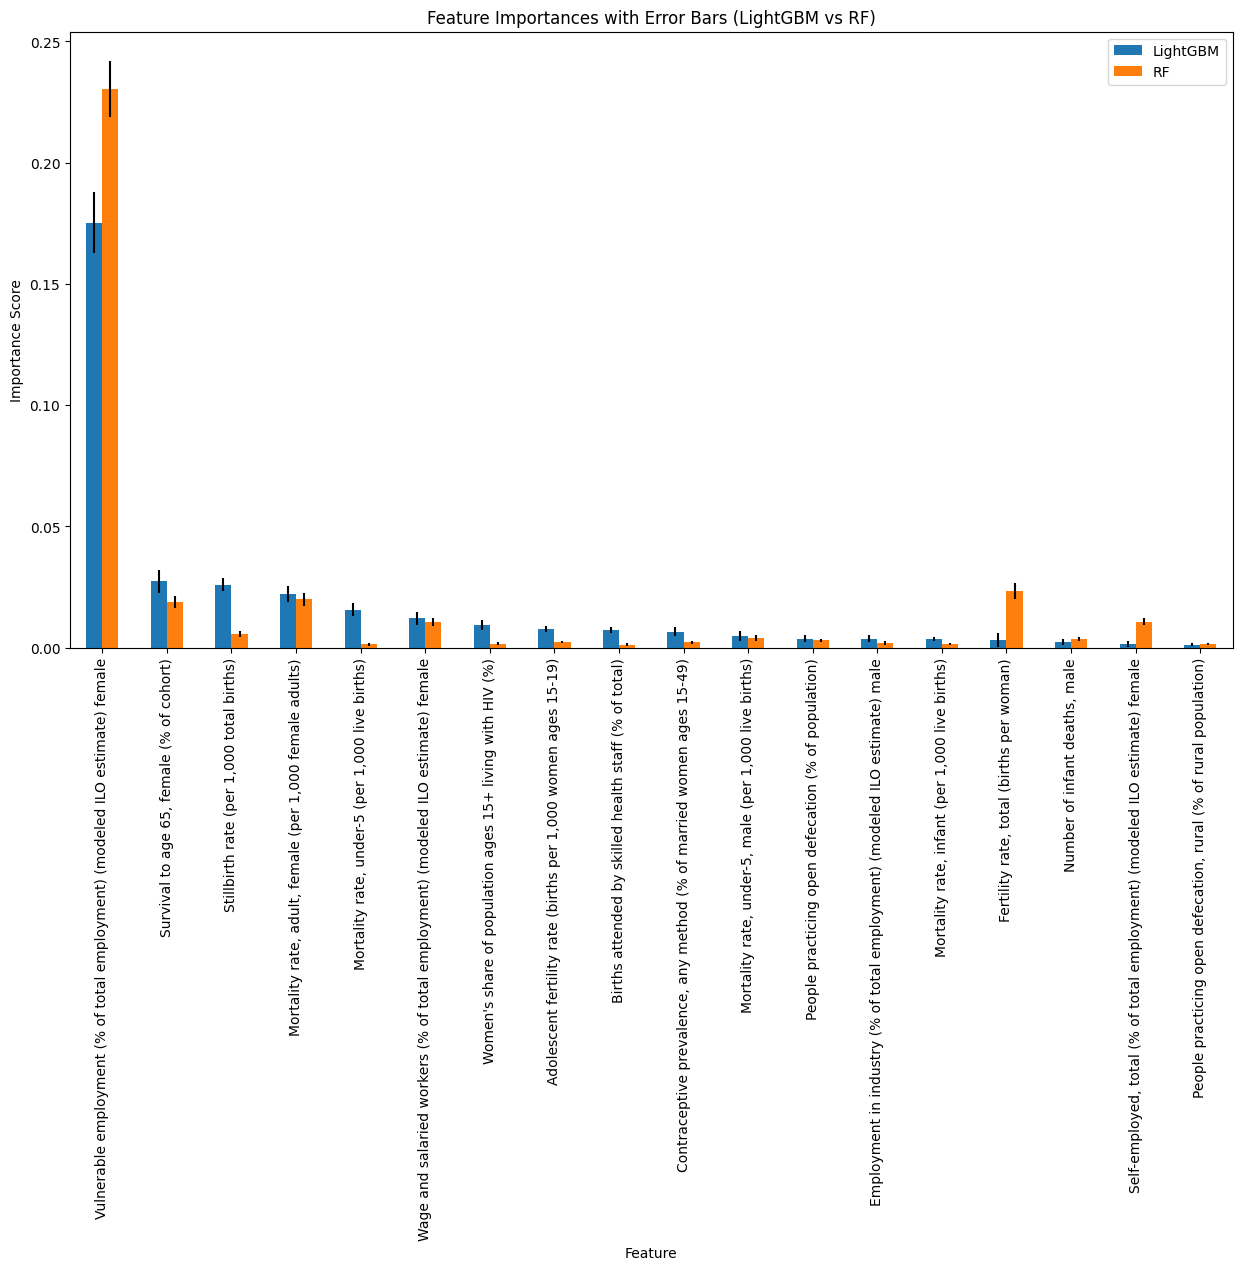

In [47]:
data_to_plot.index = data_to_plot['Feature']
data_to_plot[['LightGBM', 'RF']].plot.bar(figsize=(15, 8), yerr=data_to_plot[['Std LightGBM', 'Std RF']].to_numpy().T)
plt.ylabel("Importance Score")
plt.title("Feature Importances with Error Bars (LightGBM vs RF)")